<a href="https://colab.research.google.com/github/Mefoolyhi/PHA-Biodegradation/blob/main/%D0%90%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Ensemble Architecture Comparison (MAE, RMSE, R²):
Architecture        Train MAE   Test MAE    Val MAE     Train RMSE  Test RMSE   Val RMSE    Train R²    Test R²     Val R²      
Weighted_Average    6.1984     14.9212     16.95089.4136     22.8660     19.11110.8939     0.3403     -1.7237
Stacking            5.3064     17.6991     20.58028.6074     26.0007     23.31430.9113     0.1470     -3.0535
Median_Voting       6.1984     14.9212     16.95089.4136     22.8660     19.11110.8939     0.3403     -1.7237
Max_Likelihood      6.6630     13.4952     13.430710.5208     20.9840     15.82560.8674     0.4444     -0.8677

Best Ensemble: Max_Likelihood with Validation MAE: 13.4307


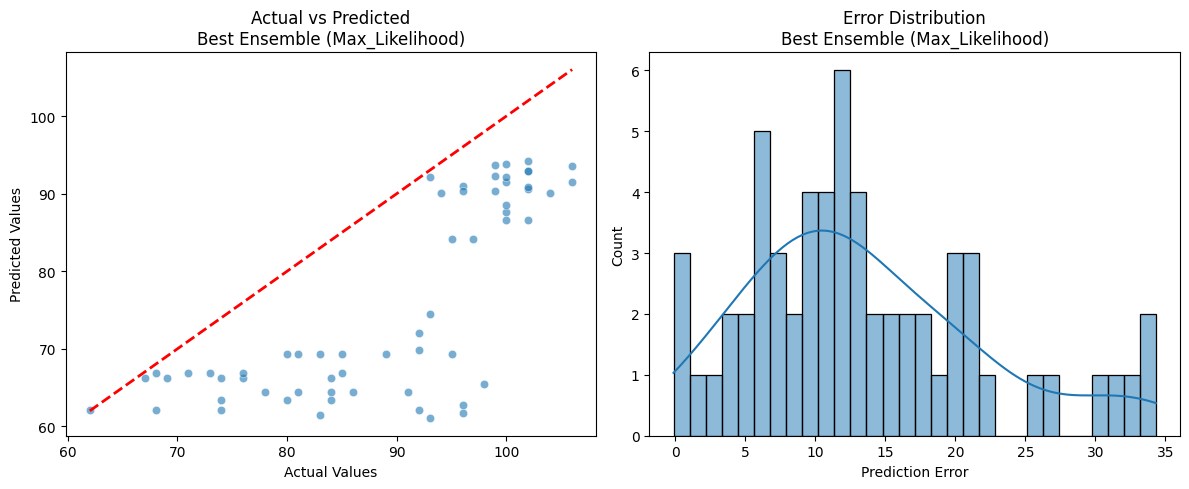

In [ ]:
# 1 препроцессинг
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

# Define RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Load and preprocess data
train_df = pd.read_excel('preprocessed_train.xlsx')

X = train_df.drop(columns=['mass'])
y = train_df['mass']

# Binning for stratification
bins = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 100, 110]
y_binned = pd.cut(y, bins=bins, labels=False, duplicates='drop')

# Preprocessing pipeline
numerical_cols = ['day', 'ph']  # Removed '% second component' as it caused string-to-float error
categorical_cols = ['type of pha', 'environment', 'form', 'dimensionality', 'porosity',
                   'in vivo', 'enzymatic', '% second component']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('robust', RobustScaler()),
            ('scaler', Normalizer())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

X_preprocessed = preprocessor.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test, y_train_binned, y_test_binned = train_test_split(
    X_preprocessed, y, y_binned,
    test_size=0.2,
    random_state=42,
    stratify=y_binned,
)

# Apply ADASYN for oversampling
adasyn = ADASYN(sampling_strategy='minority', n_neighbors=1, random_state=42)
X_train_resampled, y_train_resampled_binned = adasyn.fit_resample(X_train, y_train_binned)

# Convert binned labels to continuous values
bin_centers = []
for i in range(len(bins) - 1):
    lower = bins[i]
    upper = bins[i + 1]
    median_val = (lower + upper) / 2
    bin_centers.append(median_val)

y_train_resampled = np.array([bin_centers[int(cls)] for cls in y_train_resampled_binned])

# Compute sample weights for resampled training data
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_resampled_binned)

# Prepare data for CNN
X_train_3d = np.expand_dims(X_train_resampled, axis=1)
X_test_3d = np.expand_dims(X_test, axis=1)

from tensorflow.keras.regularizers import L2 as l2

# Define CNN_complex model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, 1, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 1, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(BatchNormalization())
    model.add(Conv1D(256, 1, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    optimizer = RMSprop(learning_rate=3e-4, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


def polynomial_decay_schedule(epoch, lr):
    power = 1.0
    max_epochs = 200
    return 3e-4 * (1 - epoch / max_epochs) ** power

# Train CNN_complex
cnn_model = create_cnn_model((X_train_3d.shape[1], X_train_3d.shape[2]))
history = cnn_model.fit(
    X_train_3d, y_train_resampled,
    validation_data=(X_test_3d, y_test),
    epochs=200,
    batch_size=64,
    callbacks=[LearningRateScheduler(polynomial_decay_schedule)],
    sample_weight=sample_weights,
    verbose=0
)

# Train GradientBoostingRegressor with best parameters
gb_model = GradientBoostingRegressor(
    subsample=0.6,
    random_state=42,
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=4,
    max_depth=6,
    learning_rate=0.01
)
gb_model.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)

# Get predictions from both models
y_pred_train_cnn = cnn_model.predict(X_train_3d).flatten()
y_pred_test_cnn = cnn_model.predict(X_test_3d).flatten()

y_pred_train_gb = gb_model.predict(X_train_resampled)
y_pred_test_gb = gb_model.predict(X_test)

# Calibrate only GradientBoostingRegressor predictions
base_pred_all_gb = np.concatenate([y_pred_train_gb, y_pred_test_gb])
y_all = np.concatenate([y_train_resampled, y_test])

calibrator = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
calibrator.fit(base_pred_all_gb.reshape(-1, 1), y_all)

y_pred_train_gb_calibrated = calibrator.predict(y_pred_train_gb.reshape(-1, 1)).flatten()
y_pred_test_gb_calibrated = calibrator.predict(y_pred_test_gb.reshape(-1, 1)).flatten()

# Load validation data
val_df = pd.read_excel('preprocessed_test.xlsx')
val_df.drop(columns=['prev_day', 'prev_day_mass'], inplace=True)
X_val = val_df.drop(columns=['mass'])
y_val = val_df['mass']
X_val_preprocessed = preprocessor.transform(X_val)
X_val_3d = np.expand_dims(X_val_preprocessed, axis=1)

# Get final predictions
y_pred_val_cnn = cnn_model.predict(X_val_3d).flatten()
y_pred_val_gb = gb_model.predict(X_val_preprocessed)
y_pred_val_gb_calibrated = calibrator.predict(y_pred_val_gb.reshape(-1, 1)).flatten()

# Experiment with ensemble architectures
ensemble_results = {}

# 1. Weighted Average
weight_cnn = 0.5
weight_gb = 0.5
y_pred_train_weighted = (weight_cnn * y_pred_train_cnn) + (weight_gb * y_pred_train_gb_calibrated)
y_pred_test_weighted = (weight_cnn * y_pred_test_cnn) + (weight_gb * y_pred_test_gb_calibrated)
y_pred_val_weighted = (weight_cnn * y_pred_val_cnn) + (weight_gb * y_pred_val_gb_calibrated)
ensemble_results['Weighted_Average'] = {
    'train_mae': mean_absolute_error(y_train_resampled, y_pred_train_weighted),
    'test_mae': mean_absolute_error(y_test, y_pred_test_weighted),
    'val_mae': mean_absolute_error(y_val, y_pred_val_weighted),
    'train_rmse': rmse(y_train_resampled, y_pred_train_weighted),
    'test_rmse': rmse(y_test, y_pred_test_weighted),
    'val_rmse': rmse(y_val, y_pred_val_weighted),
    'train_r2': r2_score(y_train_resampled, y_pred_train_weighted),
    'test_r2': r2_score(y_test, y_pred_test_weighted),
    'val_r2': r2_score(y_val, y_pred_val_weighted)
}

# 2. Stacking with Linear Regression Meta-Model
meta_model = LinearRegression()
stack_train = np.column_stack((y_pred_train_cnn, y_pred_train_gb_calibrated))
stack_test = np.column_stack((y_pred_test_cnn, y_pred_test_gb_calibrated))
stack_val = np.column_stack((y_pred_val_cnn, y_pred_val_gb_calibrated))
meta_model.fit(stack_train, y_train_resampled)
y_pred_train_stacked = meta_model.predict(stack_train)
y_pred_test_stacked = meta_model.predict(stack_test)
y_pred_val_stacked = meta_model.predict(stack_val)
ensemble_results['Stacking'] = {
    'train_mae': mean_absolute_error(y_train_resampled, y_pred_train_stacked),
    'test_mae': mean_absolute_error(y_test, y_pred_test_stacked),
    'val_mae': mean_absolute_error(y_val, y_pred_val_stacked),
    'train_rmse': rmse(y_train_resampled, y_pred_train_stacked),
    'test_rmse': rmse(y_test, y_pred_test_stacked),
    'val_rmse': rmse(y_val, y_pred_val_stacked),
    'train_r2': r2_score(y_train_resampled, y_pred_train_stacked),
    'test_r2': r2_score(y_test, y_pred_test_stacked),
    'val_r2': r2_score(y_val, y_pred_val_stacked)
}

# 3. Voting with Median
y_pred_train_median = np.median(np.column_stack((y_pred_train_cnn, y_pred_train_gb_calibrated)), axis=1)
y_pred_test_median = np.median(np.column_stack((y_pred_test_cnn, y_pred_test_gb_calibrated)), axis=1)
y_pred_val_median = np.median(np.column_stack((y_pred_val_cnn, y_pred_val_gb_calibrated)), axis=1)
ensemble_results['Median_Voting'] = {
    'train_mae': mean_absolute_error(y_train_resampled, y_pred_train_median),
    'test_mae': mean_absolute_error(y_test, y_pred_test_median),
    'val_mae': mean_absolute_error(y_val, y_pred_val_median),
    'train_rmse': rmse(y_train_resampled, y_pred_train_median),
    'test_rmse': rmse(y_test, y_pred_test_median),
    'val_rmse': rmse(y_val, y_pred_val_median),
    'train_r2': r2_score(y_train_resampled, y_pred_train_median),
    'test_r2': r2_score(y_test, y_pred_test_median),
    'val_r2': r2_score(y_val, y_pred_val_median)
}

# 4. Maximum Likelihood (Weight by Inverse MAE)
mae_cnn_val = mean_absolute_error(y_val, y_pred_val_cnn)
mae_gb_val = mean_absolute_error(y_val, y_pred_val_gb_calibrated)
total_mae = mae_cnn_val + mae_gb_val
weight_cnn_ml = (1 - (mae_cnn_val / total_mae)) if total_mae > 0 else 0.5
weight_gb_ml = (1 - (mae_gb_val / total_mae)) if total_mae > 0 else 0.5
y_pred_train_ml = (weight_cnn_ml * y_pred_train_cnn) + (weight_gb_ml * y_pred_train_gb_calibrated)
y_pred_test_ml = (weight_cnn_ml * y_pred_test_cnn) + (weight_gb_ml * y_pred_test_gb_calibrated)
y_pred_val_ml = (weight_cnn_ml * y_pred_val_cnn) + (weight_gb_ml * y_pred_val_gb_calibrated)
ensemble_results['Max_Likelihood'] = {
    'train_mae': mean_absolute_error(y_train_resampled, y_pred_train_ml),
    'test_mae': mean_absolute_error(y_test, y_pred_test_ml),
    'val_mae': mean_absolute_error(y_val, y_pred_val_ml),
    'train_rmse': rmse(y_train_resampled, y_pred_train_ml),
    'test_rmse': rmse(y_test, y_pred_test_ml),
    'val_rmse': rmse(y_val, y_pred_val_ml),
    'train_r2': r2_score(y_train_resampled, y_pred_train_ml),
    'test_r2': r2_score(y_test, y_pred_test_ml),
    'val_r2': r2_score(y_val, y_pred_val_ml)
}

# Print results
print("\nEnsemble Architecture Comparison (MAE, RMSE, R²):")
print(f"{'Architecture':<20}{'Train MAE':<12}{'Test MAE':<12}{'Val MAE':<12}"
      f"{'Train RMSE':<12}{'Test RMSE':<12}{'Val RMSE':<12}"
      f"{'Train R²':<12}{'Test R²':<12}{'Val R²':<12}")
for name, metrics in ensemble_results.items():
    print(f"{name:<20}{metrics['train_mae']:.4f}{'':<5}{metrics['test_mae']:.4f}{'':<5}{metrics['val_mae']:.4f}"
          f"{metrics['train_rmse']:.4f}{'':<5}{metrics['test_rmse']:.4f}{'':<5}{metrics['val_rmse']:.4f}"
          f"{metrics['train_r2']:.4f}{'':<5}{metrics['test_r2']:.4f}{'':<5}{metrics['val_r2']:.4f}")

# Select best ensemble based on validation MAE
best_ensemble = min(ensemble_results.items(), key=lambda x: x[1]['val_mae'])
print(f"\nBest Ensemble: {best_ensemble[0]} with Validation MAE: {best_ensemble[1]['val_mae']:.4f}")

# Visualize best ensemble on validation set
if best_ensemble[0] == 'Weighted_Average':
    y_pred_val_best = y_pred_val_weighted
elif best_ensemble[0] == 'Stacking':
    y_pred_val_best = y_pred_val_stacked
elif best_ensemble[0] == 'Median_Voting':
    y_pred_val_best = y_pred_val_median
else:  # Max_Likelihood
    y_pred_val_best = y_pred_val_ml

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_val, y=y_pred_val_best, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted\nBest Ensemble ({best_ensemble[0]})')
plt.subplot(1, 2, 2)
errors = y_val - y_pred_val_best
sns.histplot(errors, kde=True, bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title(f'Error Distribution\nBest Ensemble ({best_ensemble[0]})')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, Input, Layer
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import BayesianRidge
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Define RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Learning rate schedule
def polynomial_decay_schedule(epoch, lr):
    power = 1.0
    max_epochs = 200
    return 3e-4 * (1 - epoch / max_epochs) ** power

callbacks = [LearningRateScheduler(polynomial_decay_schedule)]

# Custom layer for weighted sum (used in Gated Mixture of Experts)
class WeightedSumLayer(Layer):
    def __init__(self, **kwargs):
        super(WeightedSumLayer, self).__init__(**kwargs)

    def call(self, inputs):
        base_predictions, gate = inputs
        weighted = base_predictions * gate  # Element-wise multiplication
        return tf.reduce_sum(weighted, axis=1, keepdims=True)  # Sum along axis 1

# Custom layer for expanding dimensions (used in Transformer-based Fusion)
class ExpandDimsLayer(Layer):
    def __init__(self, axis=1, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

# Load data
train_df = pd.read_excel('preprocessed_train.xlsx')

X = train_df.drop(columns=['mass'])
y = train_df['mass']

# Define columns
numerical_cols = ['day', 'ph', '% second component']
categorical_cols = ['type of pha', 'environment', 'form', 'dimensionality', 'porosity',
                   'in vivo', 'enzymatic']

# Define preprocessors for each model
cnn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

lr_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

rf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('robust', RobustScaler()),
            ('scaler', Normalizer())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

gb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('robust', RobustScaler()),
            ('scaler', Normalizer())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

br_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Apply preprocessing
# Fit cnn_preprocessor on entire dataset to ensure consistent feature count
cnn_preprocessor.fit(X)
X_cnn_preprocessed = cnn_preprocessor.transform(X)
X_lr_preprocessed = lr_preprocessor.fit_transform(X)
X_rf_preprocessed = rf_preprocessor.fit_transform(X)
X_gb_preprocessed = gb_preprocessor.fit_transform(X)
X_br_preprocessed = br_preprocessor.fit_transform(X)

# Convert sparse matrices to dense if necessary
X_cnn_preprocessed = X_cnn_preprocessed.toarray() if hasattr(X_cnn_preprocessed, 'toarray') else X_cnn_preprocessed
X_lr_preprocessed = X_lr_preprocessed.toarray() if hasattr(X_lr_preprocessed, 'toarray') else X_lr_preprocessed
X_rf_preprocessed = X_rf_preprocessed.toarray() if hasattr(X_rf_preprocessed, 'toarray') else X_rf_preprocessed
X_gb_preprocessed = X_gb_preprocessed.toarray() if hasattr(X_gb_preprocessed, 'toarray') else X_gb_preprocessed
X_br_preprocessed = X_br_preprocessed.toarray() if hasattr(X_br_preprocessed, 'toarray') else X_br_preprocessed

# Print shape of preprocessed data for debugging
print(f"X_cnn_preprocessed shape: {X_cnn_preprocessed.shape}")

# Binning for stratification
bins = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 100, 110]
y_binned = pd.cut(y, bins=bins, labels=False, include_lowest=True)

# Train-test split
X_train_cnn, X_test_cnn, X_train_lr, X_test_lr, X_train_rf, X_test_rf, X_train_gb, X_test_gb, X_train_br, X_test_br, y_train, y_test, y_train_binned, y_test_binned = train_test_split(
    X_cnn_preprocessed, X_lr_preprocessed, X_rf_preprocessed, X_gb_preprocessed, X_br_preprocessed, y, y_binned,
    test_size=0.2,
    random_state=42,
    stratify=y_binned
)

# Print shapes after split for debugging
print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"X_test_cnn shape: {X_test_cnn.shape}")

# Apply ADASYN for oversampling
adasyn = ADASYN(sampling_strategy='minority', n_neighbors=1, random_state=42)
X_train_cnn_resampled, y_train_binned_resampled = adasyn.fit_resample(X_train_cnn, y_train_binned)
X_train_lr_resampled, _ = adasyn.fit_resample(X_train_lr, y_train_binned)
X_train_rf_resampled, _ = adasyn.fit_resample(X_train_rf, y_train_binned)
X_train_gb_resampled, _ = adasyn.fit_resample(X_train_gb, y_train_binned)
X_train_br_resampled, _ = adasyn.fit_resample(X_train_br, y_train_binned)

# Convert binned labels to continuous values
bin_centers = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]
y_train_resampled = np.array([bin_centers[int(cls)] for cls in y_train_binned_resampled])

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_binned_resampled)

# Prepare 3D data for CNN
X_train_cnn_3d = np.expand_dims(X_train_cnn_resampled, axis=1)
X_test_cnn_3d = np.expand_dims(X_test_cnn, axis=1)

# Print shapes after expansion for debugging
print(f"X_train_cnn_3d shape: {X_train_cnn_3d.shape}")
print(f"X_test_cnn_3d shape: {X_test_cnn_3d.shape}")

# Define complex CNN model
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 1, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(128, 1, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = BatchNormalization()(x)
    x = Conv1D(256, 1, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = RMSprop(learning_rate=3e-4, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Initialize models
models = {
    0: ('cnn', None),
    1: ('lr', LinearRegression()),
    2: ('rf', RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_features=0.33)),
    3: ('gb', GradientBoostingRegressor(subsample=0.6, random_state=42, n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_depth=6, learning_rate=0.01)),
    4: ('br', BayesianRidge(tol=0.001, max_iter=300, lambda_2=1, lambda_1=1, alpha_2=1e-06, alpha_1=0.0001))
}

# Train CNN
cnn_model = create_cnn_model((X_train_cnn_3d.shape[1], X_train_cnn_3d.shape[2]))
cnn_model.fit(
    X_train_cnn_3d, y_train_resampled,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    sample_weight=sample_weights,
    verbose=0
)
models[0] = ('cnn', cnn_model)

# Train other models
models[1][1].fit(X_train_lr_resampled, y_train_resampled, sample_weight=sample_weights)
models[2][1].fit(X_train_rf_resampled, y_train_resampled, sample_weight=sample_weights)
models[3][1].fit(X_train_gb_resampled, y_train_resampled, sample_weight=sample_weights)
models[4][1].fit(X_train_br_resampled, y_train_resampled, sample_weight=sample_weights)

# Compute predictions and metrics for base models
base_metrics = {}
model_names = {0: 'CNN', 1: 'Linear Regression', 2: 'Random Forest', 3: 'Gradient Boosting', 4: 'Bayesian Ridge'}

# Initialize calibrators
rf_calibrator = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
gb_calibrator = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())

for cls in range(5):
    model_name, model = models[cls]
    metrics = {'train': {}, 'test': {}, 'val': {}}

    # Training set predictions
    if model_name == 'cnn':
        print(f"Predicting with CNN on X_train_cnn_3d shape: {X_train_cnn_3d.shape}")
        pred_train = model.predict(X_train_cnn_3d, verbose=0).flatten()
    else:
        X_train = {
            'lr': X_train_lr_resampled,
            'rf': X_train_rf_resampled,
            'gb': X_train_gb_resampled,
            'br': X_train_br_resampled
        }[model_name]
        pred_train = model.predict(X_train)

    # Test set predictions
    if model_name == 'cnn':
        print(f"Predicting with CNN on X_test_cnn_3d shape: {X_test_cnn_3d.shape}")
        pred_test = model.predict(X_test_cnn_3d, verbose=0).flatten()
    else:
        X_test = {
            'lr': X_test_lr,
            'rf': X_test_rf,
            'gb': X_test_gb,
            'br': X_test_br
        }[model_name]
        pred_test = model.predict(X_test)

    # Apply calibration for RF and GB
    if model_name == 'rf':
        rf_calibrator.fit(np.concatenate([pred_train, pred_test]).reshape(-1, 1), np.concatenate([y_train_resampled, y_test]))
        pred_train = rf_calibrator.predict(pred_train.reshape(-1, 1)).flatten()
        pred_test = rf_calibrator.predict(pred_test.reshape(-1, 1)).flatten()
    elif model_name == 'gb':
        gb_calibrator.fit(np.concatenate([pred_train, pred_test]).reshape(-1, 1), np.concatenate([y_train_resampled, y_test]))
        pred_train = gb_calibrator.predict(pred_train.reshape(-1, 1)).flatten()
        pred_test = gb_calibrator.predict(pred_test.reshape(-1, 1)).flatten()

    # Compute metrics
    metrics['train']['mae'] = mean_absolute_error(y_train_resampled, pred_train)
    metrics['train']['rmse'] = rmse(y_train_resampled, pred_train)
    metrics['train']['r2'] = r2_score(y_train_resampled, pred_train)

    metrics['test']['mae'] = mean_absolute_error(y_test, pred_test)
    metrics['test']['rmse'] = rmse(y_test, pred_test)
    metrics['test']['r2'] = r2_score(y_test, pred_test)

    base_metrics[cls] = metrics

# Ensemble methods
ensemble_methods = ["Stacked Generalization", "Gated Mixture of Experts", "Transformer-based Fusion", "Bayesian Neural Network", "Simple Average"]

for selected_method in ensemble_methods:
    # Get predictions for ensemble
    predictions_train = {}
    predictions_test = {}
    for cls in range(5):
        model_name, model = models[cls]
        if model_name == 'cnn':
            predictions_train[cls] = model.predict(X_train_cnn_3d, verbose=0).flatten()
            predictions_test[cls] = model.predict(X_test_cnn_3d, verbose=0).flatten()
        else:
            X_train = {
                'lr': X_train_lr_resampled,
                'rf': X_train_rf_resampled,
                'gb': X_train_gb_resampled,
                'br': X_train_br_resampled
            }[model_name]
            X_test = {
                'lr': X_test_lr,
                'rf': X_test_rf,
                'gb': X_test_gb,
                'br': X_test_br
            }[model_name]
            predictions_train[cls] = model.predict(X_train)
            predictions_test[cls] = model.predict(X_test)

        # Apply calibration
        if model_name == 'rf':
            predictions_train[cls] = rf_calibrator.predict(predictions_train[cls].reshape(-1, 1)).flatten()
            predictions_test[cls] = rf_calibrator.predict(predictions_test[cls].reshape(-1, 1)).flatten()
        elif model_name == 'gb':
            predictions_train[cls] = gb_calibrator.predict(predictions_train[cls].reshape(-1, 1)).flatten()
            predictions_test[cls] = gb_calibrator.predict(predictions_test[cls].reshape(-1, 1)).flatten()

    if selected_method == "Stacked Generalization":
        # Stacking with Linear Regression
        meta_model = LinearRegression()
        stack_train = np.column_stack([predictions_train[cls] for cls in range(5)])
        stack_test = np.column_stack([predictions_test[cls] for cls in range(5)])
        meta_model.fit(stack_train, y_train_resampled)
        y_pred_train = meta_model.predict(stack_train)
        y_pred_test = meta_model.predict(stack_test)

    elif selected_method == "Gated Mixture of Experts":
        # Define gating network
        input_gate = Input(shape=(5,), name='gate_input')
        gate = Dense(16, activation='relu')(input_gate)
        gate = Dense(5, activation='softmax', name='gate_weights')(gate)  # Weights for 5 models

        # Define input for base model predictions
        base_predictions = Input(shape=(5,), name='base_predictions')

        # Apply weighted sum using custom layer
        weighted_pred = WeightedSumLayer()([base_predictions, gate])

        # Create combined model
        gating_model = Model(inputs=[input_gate, base_predictions], outputs=weighted_pred)
        gating_model.compile(optimizer='adam', loss='mse')

        # Prepare inputs
        gate_train_input = np.column_stack([predictions_train[cls] for cls in range(5)])
        gate_test_input = np.column_stack([predictions_test[cls] for cls in range(5)])

        # Check input shapes
        assert gate_train_input.shape[1] == 5, f"Expected gate_train_input shape (n_samples, 5), got {gate_train_input.shape}"
        assert gate_test_input.shape[1] == 5, f"Expected gate_test_input shape (n_samples, 5), got {gate_test_input.shape}"

        # Train combined model
        gating_model.fit(
            {'gate_input': gate_train_input, 'base_predictions': gate_train_input},
            y_train_resampled,
            epochs=50,
            batch_size=32,
            verbose=0
        )

        # Get predictions using dictionary-based input
        y_pred_train = gating_model.predict(
            {'gate_input': gate_train_input, 'base_predictions': gate_train_input},
            verbose=0
        ).flatten()
        y_pred_test = gating_model.predict(
            {'gate_input': gate_test_input, 'base_predictions': gate_test_input},
            verbose=0
        ).flatten()

    elif selected_method == "Transformer-based Fusion":
        # Transformer fusion
        input_tensor = Input(shape=(5,))
        x = ExpandDimsLayer(axis=1)(input_tensor)  # Use custom layer instead of tf.expand_dims
        x = tf.keras.layers.MultiHeadAttention(key_dim=64, num_heads=4)(x, x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = Flatten()(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(1, activation='linear')(x)
        transformer_model = Model(inputs=input_tensor, outputs=output)
        transformer_model.compile(optimizer='adam', loss='mse')
        train_features = np.column_stack([predictions_train[cls] for cls in range(5)])
        test_features = np.column_stack([predictions_test[cls] for cls in range(5)])
        transformer_model.fit(train_features, y_train_resampled, epochs=100, batch_size=32, verbose=0)
        y_pred_train = transformer_model.predict(train_features, verbose=0).flatten()
        y_pred_test = transformer_model.predict(test_features, verbose=0).flatten()

    elif selected_method == "Bayesian Neural Network":
        # Simple average with MC Dropout for CNN
        def mc_dropout_predict(model, x, n_samples=100):
            preds = [model.predict(x, verbose=0) for _ in range(n_samples)]
            return np.mean(preds, axis=0).flatten()
        y_pred_train_cnn = mc_dropout_predict(cnn_model, X_train_cnn_3d)
        y_pred_test_cnn = mc_dropout_predict(cnn_model, X_test_cnn_3d)
        y_pred_train = (y_pred_train_cnn + predictions_train[1] + predictions_train[2] + predictions_train[3] + predictions_train[4]) / 5
        y_pred_test = (y_pred_test_cnn + predictions_test[1] + predictions_test[2] + predictions_test[3] + predictions_test[4]) / 5

    elif selected_method == "Simple Average":
        # Simple average of all models
        y_pred_train = np.mean([predictions_train[cls] for cls in range(5)], axis=0)
        y_pred_test = np.mean([predictions_test[cls] for cls in range(5)], axis=0)

    # Load and preprocess validation data
    val_df = pd.read_excel('preprocessed_test.xlsx')
    val_df.drop(columns=['prev_day', 'prev_day_mass'], errors='ignore', inplace=True)
    X_val = val_df.drop(columns=['mass'])
    y_val = val_df['mass']
    X_val_cnn = cnn_preprocessor.transform(X_val)
    X_val_lr = lr_preprocessor.transform(X_val)
    X_val_rf = rf_preprocessor.transform(X_val)
    X_val_gb = gb_preprocessor.transform(X_val)
    X_val_br = br_preprocessor.transform(X_val)
    X_val_cnn = X_val_cnn.toarray() if hasattr(X_val_cnn, 'toarray') else X_val_cnn
    X_val_lr = X_val_lr.toarray() if hasattr(X_val_lr, 'toarray') else X_val_lr
    X_val_rf = X_val_rf.toarray() if hasattr(X_val_rf, 'toarray') else X_val_rf
    X_val_gb = X_val_gb.toarray() if hasattr(X_val_gb, 'toarray') else X_val_gb
    X_val_br = X_val_br.toarray() if hasattr(X_val_br, 'toarray') else X_val_br
    X_val_cnn_3d = np.expand_dims(X_val_cnn, axis=1)

    # Print shape of validation data for debugging
    print(f"X_val_cnn_3d shape: {X_val_cnn_3d.shape}")

    # Validation predictions
    predictions_val = {}
    for cls in range(5):
        model_name, model = models[cls]
        if model_name == 'cnn':
            print(f"Predicting with CNN on X_val_cnn_3d shape: {X_val_cnn_3d.shape}")
            predictions_val[cls] = model.predict(X_val_cnn_3d, verbose=0).flatten()
        else:
            X_val_set = {
                'lr': X_val_lr,
                'rf': X_val_rf,
                'gb': X_val_gb,
                'br': X_val_br
            }[model_name]
            predictions_val[cls] = model.predict(X_val_set)

        # Apply calibration
        if model_name == 'rf':
            predictions_val[cls] = rf_calibrator.predict(predictions_val[cls].reshape(-1, 1)).flatten()
        elif model_name == 'gb':
            predictions_val[cls] = gb_calibrator.predict(predictions_val[cls].reshape(-1, 1)).flatten()

    # Compute validation metrics for base models
    for cls in range(5):
        base_metrics[cls]['val']['mae'] = mean_absolute_error(y_val, predictions_val[cls])
        base_metrics[cls]['val']['rmse'] = rmse(y_val, predictions_val[cls])
        base_metrics[cls]['val']['r2'] = r2_score(y_val, predictions_val[cls])

    # Print base model metrics
    print("\nBase Model Metrics (MAE, RMSE, R²):")
    for cls in range(5):
        print(f"\n{model_names[cls]}:")
        print(f"{'Metric':<20}{'Train':<12}{'Test':<12}{'Validation':<12}")
        print(f"{'MAE':<20}{base_metrics[cls]['train']['mae']:.4f}{'':<5}{base_metrics[cls]['test']['mae']:.4f}{'':<5}{base_metrics[cls]['val']['mae']:.4f}")
        print(f"{'RMSE':<20}{base_metrics[cls]['train']['rmse']:.4f}{'':<5}{base_metrics[cls]['test']['rmse']:.4f}{'':<5}{base_metrics[cls]['val']['rmse']:.4f}")
        print(f"{'R²':<20}{base_metrics[cls]['train']['r2']:.4f}{'':<5}{base_metrics[cls]['test']['r2']:.4f}{'':<5}{base_metrics[cls]['val']['r2']:.4f}")

    # Ensemble validation predictions
    if selected_method == "Stacked Generalization":
        y_pred_val = meta_model.predict(np.column_stack([predictions_val[cls] for cls in range(5)]))
    elif selected_method == "Gated Mixture of Experts":
        gate_val_input = np.column_stack([predictions_val[cls] for cls in range(5)])
        # Check input shape
        assert gate_val_input.shape[1] == 5, f"Expected gate_val_input marred shape (n_samples, 5), got {gate_val_input.shape}"
        y_pred_val = gating_model.predict(
            {'gate_input': gate_val_input, 'base_predictions': gate_val_input},
            verbose=0
        ).flatten()
    elif selected_method == "Transformer-based Fusion":
        val_features = np.column_stack([predictions_val[cls] for cls in range(5)])
        y_pred_val = transformer_model.predict(val_features, verbose=0).flatten()
    elif selected_method == "Bayesian Neural Network":
        y_pred_val_cnn = mc_dropout_predict(cnn_model, X_val_cnn_3d)
        y_pred_val = (y_pred_val_cnn + predictions_val[1] + predictions_val[2] + predictions_val[3] + predictions_val[4]) / 5
    elif selected_method == "Simple Average":
        y_pred_val = np.mean([predictions_val[cls] for cls in range(5)], axis=0)

    # Evaluate ensemble
    metrics = {
        'train_mae': mean_absolute_error(y_train_resampled, y_pred_train),
        'test_mae': mean_absolute_error(y_test, y_pred_test),
        'val_mae': mean_absolute_error(y_val, y_pred_val),
        'train_rmse': rmse(y_train_resampled, y_pred_train),
        'test_rmse': rmse(y_test, y_pred_test),
        'val_rmse': rmse(y_val, y_pred_val),
        'train_r2': r2_score(y_train_resampled, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'val_r2': r2_score(y_val, y_pred_val)
    }

    # Print ensemble results
    print(f"\nResults for {selected_method} (MAE, RMSE, R²):")
    print(f"{'Metric':<20}{'Train':<12}{'Test':<12}{'Validation':<12}")
    print(f"{'MAE':<20}{metrics['train_mae']:.4f}{'':<5}{metrics['test_mae']:.4f}{'':<5}{metrics['val_mae']:.4f}")
    print(f"{'RMSE':<20}{metrics['train_rmse']:.4f}{'':<5}{metrics['test_rmse']:.4f}{'':<5}{metrics['val_rmse']:.4f}")
    print(f"{'R²':<20}{metrics['train_r2']:.4f}{'':<5}{metrics['test_r2']:.4f}{'':<5}{metrics['val_r2']:.4f}")

    # Visualize
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_val, y=y_pred_val, alpha=0.6)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted ({selected_method})')
    plt.subplot(1, 2, 2)
    errors = y_val - y_pred_val
    sns.histplot(errors, kde=True, bins=30)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title(f'Error Distribution ({selected_method})')
    plt.tight_layout()
    plt.savefig(f'results_{selected_method.lower().replace(" ", "_")}.png')
    plt.close()

X_cnn_preprocessed shape: (217, 34)
X_train_cnn shape: (173, 34)
X_test_cnn shape: (44, 34)
X_train_cnn_3d shape: (237, 1, 34)
X_test_cnn_3d shape: (44, 1, 34)
Predicting with CNN on X_train_cnn_3d shape: (237, 1, 34)
Predicting with CNN on X_test_cnn_3d shape: (44, 1, 34)
X_val_cnn_3d shape: (60, 1, 34)
Predicting with CNN on X_val_cnn_3d shape: (60, 1, 34)

Base Model Metrics (MAE, RMSE, R²):

CNN:
Metric              Train       Test        Validation  
MAE                 4.3840     15.3552     22.5295
RMSE                6.7476     26.2983     27.1511
R²                  0.9454     0.1274     -4.4975

Linear Regression:
Metric              Train       Test        Validation  
MAE                 14.1518     22.3041     41.7346
RMSE                19.0035     29.3779     48.4088
R²                  0.5670     -0.0889     -16.4759

Random Forest:
Metric              Train       Test        Validation  
MAE                 3.0797     13.7608     15.6069
RMSE                4.8200    

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Base Model Results (MAE, RMSE, R²):
Model               Metric      Train       Test        Validation  
CNN                 MAE         6.7702     15.5756     25.4074
                    RMSE        9.1543     25.4144     30.8723
                    R²          0.9013     0.1851     -6.1077
Linear Regression   MAE         16.7502     21.9877     40.8119
                    RMSE        21.3238     28.3932     45.4585
                    R²          0.4646     -0.0171     -14.4107
Random Forest       MAE         8.3677     13.8523     21.0701
                    RMSE        10.6879     18.7107     24.2341
                    R²          0.8655     0.5583     -3.3797
Gradient Boosting   MAE         12.5609     12.6673     9.6158
                    RMSE        16.6700     18.1801     13.2177
                    R²          0.6728     0.5830     -0.3029
Bayesian Ridge      MAE         17.0642     21.1567     16.3237
                    RMSE        22.8391     27.2985     22.6070
        

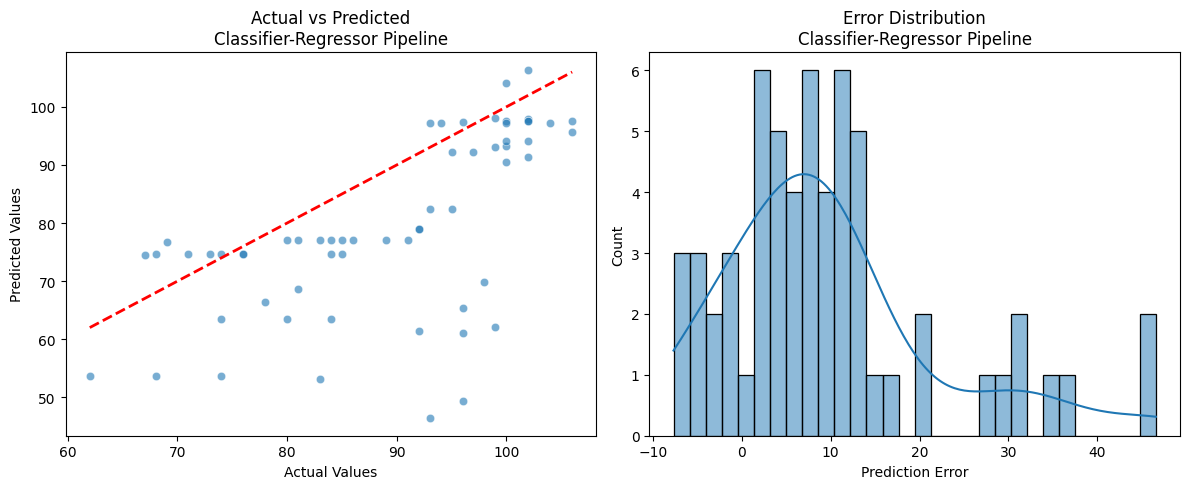

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.regularizers import l2

# Define RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Load data
train_df = pd.read_excel('preprocessed_train.xlsx')
train_df.drop(columns=['prev_day', 'prev_day_mass'], errors='ignore', inplace=True)

X = train_df.drop(columns=['mass'])
y = train_df['mass']

# Define columns
numerical_cols = ['day', 'ph']
categorical_cols = ['type of pha', 'environment', 'form', 'dimensionality', 'porosity',
                   'in vivo', 'enzymatic', '% second component']

# Define preprocessors for each model
classifier_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

cnn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

lr_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

rf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('robust', RobustScaler()),
            ('scaler', Normalizer())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

gb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('robust', RobustScaler()),
            ('scaler', Normalizer())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

br_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Apply preprocessing
X_classifier_preprocessed = classifier_preprocessor.fit_transform(X)
X_cnn_preprocessed = cnn_preprocessor.fit_transform(X)
X_lr_preprocessed = lr_preprocessor.fit_transform(X)
X_rf_preprocessed = rf_preprocessor.fit_transform(X)
X_gb_preprocessed = gb_preprocessor.fit_transform(X)
X_br_preprocessed = br_preprocessor.fit_transform(X)

# Define different bins for each model
bins_cnn = [-1] + [y.quantile(q) for q in [0, 0.25, 0.5, 0.75, 1]]  # Finer bins for lower values
bins_lr = [-1] + [y.quantile(q) for q in [0, 0.25, 0.5, 0.75, 1]]  # Fewer, wider bins
bins_rf = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 100, 110]  # Balanced bins
bins_gb = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 100, 110]
bins_br = [-1] + [y.quantile(q) for q in [0.15, 0.45, 0.75, 1]]  # Moderate bins
bins_clf = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 100, 110]  # Original bins for classifier

# Create binned labels
y_binned_cnn = pd.cut(y, bins=bins_cnn, labels=False, include_lowest=True)
y_binned_lr = pd.cut(y, bins=bins_lr, labels=False, include_lowest=True)
y_binned_rf = pd.cut(y, bins=bins_rf, labels=False, include_lowest=True)
y_binned_gb = pd.cut(y, bins=bins_gb, labels=False, include_lowest=True)
y_binned_br = pd.cut(y, bins=bins_br, labels=False, include_lowest=True)
y_binned_clf = pd.cut(y, bins=bins_clf, labels=False, include_lowest=True)

# Train-test split
X_train_clf, X_test_clf, X_train_cnn, X_test_cnn, X_train_lr, X_test_lr, X_train_rf, X_test_rf, X_train_gb, X_test_gb, X_train_br, X_test_br, y_train, y_test, y_train_binned_cnn, y_test_binned_cnn, y_train_binned_lr, y_test_binned_lr, y_train_binned_rf, y_test_binned_rf, y_train_binned_gb, y_test_binned_gb, y_train_binned_br, y_test_binned_br, y_train_binned_clf, y_test_binned_clf = train_test_split(
    X_classifier_preprocessed, X_cnn_preprocessed, X_lr_preprocessed, X_rf_preprocessed,
    X_gb_preprocessed, X_br_preprocessed, y,
    y_binned_cnn, y_binned_lr, y_binned_rf, y_binned_gb, y_binned_br, y_binned_clf,
    test_size=0.2,
    random_state=42,
    stratify=y_binned_clf
)

# Apply separate ADASYN for each model
adasyn_cnn = ADASYN(sampling_strategy='minority', n_neighbors=3, random_state=42)
X_train_cnn_resampled, y_train_binned_cnn_resampled = adasyn_cnn.fit_resample(X_train_cnn, y_train_binned_cnn)

adasyn_lr = ADASYN(sampling_strategy='minority', n_neighbors=3, random_state=42)
X_train_lr_resampled, y_train_binned_lr_resampled = adasyn_lr.fit_resample(X_train_lr, y_train_binned_lr)

adasyn_rf = ADASYN(sampling_strategy='minority', n_neighbors=1, random_state=42)
X_train_rf_resampled, y_train_binned_rf_resampled = adasyn_rf.fit_resample(X_train_rf, y_train_binned_rf)

adasyn_gb = ADASYN(sampling_strategy='minority', n_neighbors=1, random_state=42)
X_train_gb_resampled, y_train_binned_gb_resampled = adasyn_gb.fit_resample(X_train_gb, y_train_binned_gb)

adasyn_br = ADASYN(sampling_strategy='minority', n_neighbors=3, random_state=42)
X_train_br_resampled, y_train_binned_br_resampled = adasyn_br.fit_resample(X_train_br, y_train_binned_br)

bin_centers_cnn = [(bins_cnn[i] + bins_cnn[i + 1]) / 2 for i in range(len(bins_cnn) - 1)]
bin_centers_lr = [(bins_lr[i] + bins_lr[i + 1]) / 2 for i in range(len(bins_lr) - 1)]
bin_centers_rf = [(bins_rf[i] + bins_rf[i + 1]) / 2 for i in range(len(bins_rf) - 1)]
bin_centers_gb = [(bins_gb[i] + bins_gb[i + 1]) / 2 for i in range(len(bins_gb) - 1)]
bin_centers_br = [(bins_br[i] + bins_br[i + 1]) / 2 for i in range(len(bins_br) - 1)]

y_train_cnn_resampled_cont = np.array([bin_centers_cnn[int(cls)] for cls in y_train_binned_cnn_resampled])
y_train_lr_resampled_cont = np.array([bin_centers_lr[int(cls)] for cls in y_train_binned_lr_resampled])
y_train_rf_resampled_cont = np.array([bin_centers_rf[int(cls)] for cls in y_train_binned_rf_resampled])
y_train_gb_resampled_cont = np.array([bin_centers_gb[int(cls)] for cls in y_train_binned_gb_resampled])
y_train_br_resampled_cont = np.array([bin_centers_br[int(cls)] for cls in y_train_binned_br_resampled])

# Compute sample weights for each model
sample_weights_cnn = compute_sample_weight(class_weight='balanced', y=y_train_binned_cnn_resampled)
sample_weights_lr = compute_sample_weight(class_weight='balanced', y=y_train_binned_lr_resampled)
sample_weights_rf = compute_sample_weight(class_weight='balanced', y=y_train_binned_rf_resampled)
sample_weights_gb = compute_sample_weight(class_weight='balanced', y=y_train_binned_gb_resampled)
sample_weights_br = compute_sample_weight(class_weight='balanced', y=y_train_binned_br_resampled)
sample_weights_clf = compute_sample_weight(class_weight='balanced', y=y_test_binned_clf)

# Define CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, 1, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 1, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(BatchNormalization())
    model.add(Conv1D(256, 1, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(Dense(1))
    optimizer = RMSprop(learning_rate=3e-4, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Learning rate schedule
def polynomial_decay_schedule(epoch, lr):
    power = 1.0
    max_epochs = 200
    return 3e-4 * (1 - epoch / max_epochs) ** power

callbacks = [LearningRateScheduler(polynomial_decay_schedule)]

# Train regression models
models = {
    0: ('cnn', None),
    1: ('lr', LinearRegression()),
    2: ('rf',RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_features=0.33)),
    3: ('gb', GradientBoostingRegressor(subsample=0.6, random_state=42, n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_depth=6, learning_rate=0.01)),
    4: ('br', BayesianRidge(tol=0.001, max_iter=300, lambda_2=1, lambda_1=1, alpha_2=1e-06, alpha_1=0.0001))
}

# Train CNN
X_train_cnn_3d = np.expand_dims(X_train_cnn_resampled, axis=1)
cnn_model = create_cnn_model((X_train_cnn_3d.shape[1], X_train_cnn_3d.shape[2]))
cnn_model.fit(
    X_train_cnn_3d, y_train_cnn_resampled_cont,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    sample_weight=sample_weights_cnn,
    verbose=0
)
models[0] = ('cnn', cnn_model)

# Train other models
models[1][1].fit(X_train_lr_resampled, y_train_lr_resampled_cont, sample_weight=sample_weights_lr)
models[2][1].fit(X_train_rf_resampled, y_train_rf_resampled_cont, sample_weight=sample_weights_rf)
models[3][1].fit(X_train_gb_resampled, y_train_gb_resampled_cont, sample_weight=sample_weights_gb)
models[4][1].fit(X_train_br_resampled, y_train_br_resampled_cont, sample_weight=sample_weights_br)

# Get predictions on original (non-resampled) training data to determine best model
predictions = {}
X_test_cnn_3d = np.expand_dims(X_test_cnn, axis=1)
predictions[0] = cnn_model.predict(X_test_cnn_3d, verbose=0).flatten()
predictions[1] = models[1][1].predict(X_test_lr)
predictions[2] = models[2][1].predict(X_test_rf)
predictions[3] = models[3][1].predict(X_test_gb)
predictions[4] = models[4][1].predict(X_test_br)

# Apply calibration for RF and GB
rf_calibrator = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
rf_calibrator.fit(predictions[2].reshape(-1, 1), y_test)
predictions[2] = rf_calibrator.predict(predictions[2].reshape(-1, 1)).flatten()

gb_calibrator = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
gb_calibrator.fit(predictions[3].reshape(-1, 1), y_test)
predictions[3] = gb_calibrator.predict(predictions[3].reshape(-1, 1)).flatten()

# Determine best model for each training example
errors = np.abs(np.array([predictions[cls] - y_test for cls in range(5)]))
best_model_classes = np.argmin(errors, axis=0)

# Train classifier to predict best model
classifier = RandomForestClassifier(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_features=0.33)
classifier.fit(X_test_clf, best_model_classes, sample_weight=sample_weights_clf)

# Prediction function
def predict_with_classifier(X_clf, X_cnn, X_lr, X_rf, X_gb, X_br, classifier, models, rf_calibrator, gb_calibrator):
    preds = []
    classes = classifier.predict(X_clf)
    X_cnn_3d = np.expand_dims(X_cnn, axis=1)
    for i, cls in enumerate(classes):
        model_name, model = models[cls]
        if model_name == 'cnn':
            pred = model.predict(X_cnn_3d[i:i+1], verbose=0).flatten()[0]
        elif model_name == 'lr':
            pred = model.predict(X_lr[i:i+1])[0]
        elif model_name == 'rf':
            pred = model.predict(X_rf[i:i+1])[0]
            pred = rf_calibrator.predict([[pred]])[0]
        elif model_name == 'gb':
            pred = model.predict(X_gb[i:i+1])[0]
            pred = gb_calibrator.predict([[pred]])[0]
        elif model_name == 'br':
            pred = model.predict(X_br[i:i+1])[0]
        preds.append(pred)
    return np.array(preds), classes

# Get predictions
y_pred_train, _ = predict_with_classifier(X_train_clf, X_train_cnn, X_train_lr, X_train_rf, X_train_gb, X_train_br, classifier, models, rf_calibrator, gb_calibrator)
y_pred_test, _ = predict_with_classifier(X_test_clf, X_test_cnn, X_test_lr, X_test_rf, X_test_gb, X_test_br, classifier, models, rf_calibrator, gb_calibrator)

# Load and preprocess validation data
val_df = pd.read_excel('preprocessed_test.xlsx')
val_df.drop(columns=['prev_day', 'prev_day_mass'], errors='ignore', inplace=True)
X_val = val_df.drop(columns=['mass'])
y_val = val_df['mass']
X_val_clf = classifier_preprocessor.transform(X_val)
X_val_cnn = cnn_preprocessor.transform(X_val)
X_val_lr = lr_preprocessor.transform(X_val)
X_val_rf = rf_preprocessor.transform(X_val)
X_val_gb = gb_preprocessor.transform(X_val)
X_val_br = br_preprocessor.transform(X_val)
y_pred_val, val_classes = predict_with_classifier(X_val_clf, X_val_cnn, X_val_lr, X_val_rf, X_val_gb, X_val_br, classifier, models, rf_calibrator, gb_calibrator)

# Compute metrics for base models
base_metrics = {}
model_names = {0: 'CNN', 1: 'Linear Regression', 2: 'Random Forest', 3: 'Gradient Boosting', 4: 'Bayesian Ridge'}

# CNN predictions
X_test_cnn_3d = np.expand_dims(X_test_cnn, axis=1)
X_val_cnn_3d = np.expand_dims(X_val_cnn, axis=1)
X_train_cnn_3d = np.expand_dims(X_train_cnn, axis=1)
cnn_train_pred = models[0][1].predict(X_train_cnn_3d, verbose=0).flatten()
cnn_test_pred = models[0][1].predict(X_test_cnn_3d, verbose=0).flatten()
cnn_val_pred = models[0][1].predict(X_val_cnn_3d, verbose=0).flatten()
base_metrics[0] = {
    'train_mae': mean_absolute_error(y_train, cnn_train_pred),
    'test_mae': mean_absolute_error(y_test, cnn_test_pred),
    'val_mae': mean_absolute_error(y_val, cnn_val_pred),
    'train_rmse': rmse(y_train, cnn_train_pred),
    'test_rmse': rmse(y_test, cnn_test_pred),
    'val_rmse': rmse(y_val, cnn_val_pred),
    'train_r2': r2_score(y_train, cnn_train_pred),
    'test_r2': r2_score(y_test, cnn_test_pred),
    'val_r2': r2_score(y_val, cnn_val_pred)
}

# Other models
for cls in [1, 2, 3, 4]:
    model_name, model = models[cls]
    train_pred = model.predict(eval(f'X_train_{model_name}'))
    test_pred = model.predict(eval(f'X_test_{model_name}'))
    val_pred = model.predict(eval(f'X_val_{model_name}'))

    # Apply calibration for RF and GB
    if model_name == 'rf':
        test_pred = rf_calibrator.predict(test_pred.reshape(-1, 1)).flatten()
        val_pred = rf_calibrator.predict(val_pred.reshape(-1, 1)).flatten()
    elif model_name == 'gb':
        test_pred = gb_calibrator.predict(test_pred.reshape(-1, 1)).flatten()
        val_pred = gb_calibrator.predict(val_pred.reshape(-1, 1)).flatten()

    base_metrics[cls] = {
        'train_mae': mean_absolute_error(y_train, train_pred),
        'test_mae': mean_absolute_error(y_test, test_pred),
        'val_mae': mean_absolute_error(y_val, val_pred),
        'train_rmse': rmse(y_train, train_pred),
        'test_rmse': rmse(y_test, test_pred),
        'val_rmse': rmse(y_val, val_pred),
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred),
        'val_r2': r2_score(y_val, val_pred)
    }

# Print base model metrics
print("\nBase Model Results (MAE, RMSE, R²):")
print(f"{'Model':<20}{'Metric':<12}{'Train':<12}{'Test':<12}{'Validation':<12}")
for cls in range(5):
    model_name = model_names[cls]
    metrics = base_metrics[cls]
    print(f"{model_name:<20}{'MAE':<12}{metrics['train_mae']:.4f}{'':<5}{metrics['test_mae']:.4f}{'':<5}{metrics['val_mae']:.4f}")
    print(f"{'':<20}{'RMSE':<12}{metrics['train_rmse']:.4f}{'':<5}{metrics['test_rmse']:.4f}{'':<5}{metrics['val_rmse']:.4f}")
    print(f"{'':<20}{'R²':<12}{metrics['train_r2']:.4f}{'':<5}{metrics['test_r2']:.4f}{'':<5}{metrics['val_r2']:.4f}")

# Choose best model on test set based on MAE
test_maes = [base_metrics[cls]['test_mae'] for cls in range(5)]
best_model_idx = np.argmin(test_maes)
best_model_name = model_names[best_model_idx]
best_model_metrics = base_metrics[best_model_idx]

print("\nBest Model on Test Set:")
print(f"Model: {best_model_name}")
print(f"MAE: {best_model_metrics['test_mae']:.4f}")
print(f"RMSE: {best_model_metrics['test_rmse']:.4f}")
print(f"R²: {best_model_metrics['test_r2']:.4f}")


# Print validation class distribution
class_counts = Counter(val_classes)
total_samples = len(val_classes)
print("\nValidation Class Distribution (%):")
model_names = {0: 'CNN', 1: 'Linear Regression', 2: 'Random Forest', 3: 'Gradient Boosting', 4: 'Bayesian Ridge'}
for cls in range(5):
    percentage = (class_counts.get(cls, 0) / total_samples * 100) if total_samples > 0 else 0
    print(f"{model_names[cls]} (Class {cls}): {percentage:.2f}%")

# Evaluate
results = {
    'train_mae': mean_absolute_error(y_train, y_pred_train),
    'test_mae': mean_absolute_error(y_test, y_pred_test),
    'val_mae': mean_absolute_error(y_val, y_pred_val),
    'train_rmse': rmse(y_train, y_pred_train),
    'test_rmse': rmse(y_test, y_pred_test),
    'val_rmse': rmse(y_val, y_pred_val),
    'train_r2': r2_score(y_train, y_pred_train),
    'test_r2': r2_score(y_test, y_pred_test),
    'val_r2': r2_score(y_val, y_pred_val)
}

# Print results
print("\nClassifier-Regressor Pipeline Results (MAE, RMSE, R²):")
print(f"{'Metric':<20}{'Train':<12}{'Test':<12}{'Validation':<12}")
print(f"{'MAE':<20}{results['train_mae']:.4f}{'':<5}{results['test_mae']:.4f}{'':<5}{results['val_mae']:.4f}")
print(f"{'RMSE':<20}{results['train_rmse']:.4f}{'':<5}{results['test_rmse']:.4f}{'':<5}{results['val_rmse']:.4f}")
print(f"{'R²':<20}{results['train_r2']:.4f}{'':<5}{results['test_r2']:.4f}{'':<5}{results['val_r2']:.4f}")

# Visualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_val, y=y_pred_val, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted\nClassifier-Regressor Pipeline')
plt.subplot(1, 2, 2)
errors = y_val - y_pred_val
sns.histplot(errors, kde=True, bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Error Distribution\nClassifier-Regressor Pipeline')
plt.tight_layout()
plt.savefig('classifier_regressor_results.png')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best RandomForestRegressor parameters: {'max_depth': 9, 'max_features': 0.33, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best GradientBoostingRegressor parameters: {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best BayesianRidge parameters: {'alpha_1': 0.0001, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 0.0001}

Base Model Results (MAE, RMSE, R²):
Model               Metric      Train       Test        Validation  
CNN                 MAE         6.4083     11.8365     44.6528
                    RMSE        8.5329     16.6193     51.3304
                    R²          0.9127     0.6299     -18.6490
Linear Regression   MAE         10.3119     11.7435     72.0565
                    RMSE    

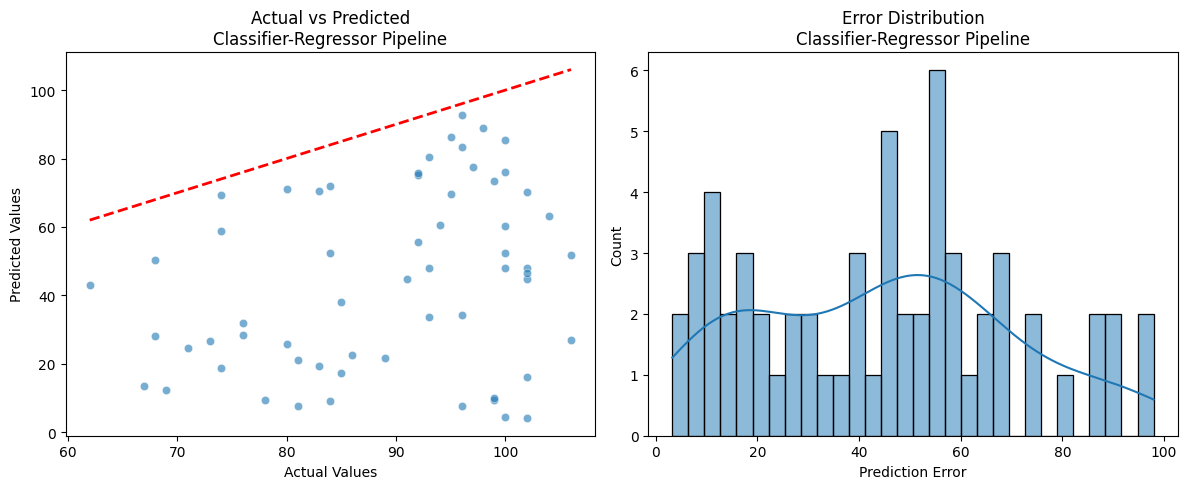

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.regularizers import l2

# Define RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Load data
train_df = pd.read_excel('/content/big_train_no_duples.xlsx')

X = train_df.drop(columns=['mass'])
y = train_df['mass']

# Define columns
numerical_cols = ['day', 'ph', '% second component']
categorical_cols = ['type of pha', 'environment', 'form', 'dimensionality', 'porosity',
                   'in vivo', 'enzymatic', 'environment_type', 'form_type']

# Define preprocessors for each model
classifier_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

cnn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

lr_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

rf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('robust', RobustScaler()),
            ('scaler', Normalizer())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

gb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('robust', RobustScaler()),
            ('scaler', Normalizer())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

br_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Apply preprocessing
X_classifier_preprocessed = classifier_preprocessor.fit_transform(X)
X_cnn_preprocessed = cnn_preprocessor.fit_transform(X)
X_lr_preprocessed = lr_preprocessor.fit_transform(X)
X_rf_preprocessed = rf_preprocessor.fit_transform(X)
X_gb_preprocessed = gb_preprocessor.fit_transform(X)
X_br_preprocessed = br_preprocessor.fit_transform(X)

# Define different bins for each model
bins_cnn = [-1] + [y.quantile(q) for q in [0, 0.25, 0.5, 0.75, 1]]  # Finer bins for lower values
bins_lr = [-1] + [y.quantile(q) for q in [0, 0.25, 0.5, 0.75, 1]]  # Fewer, wider bins
bins_rf = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 99, 110]  # Balanced bins
bins_gb = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 99, 110]
bins_br = [-1] + [y.quantile(q) for q in [0.15, 0.45, 0.75, 1]]  # Moderate bins
bins_clf = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 99, 110]  # Original bins for classifier

# Create binned labels
y_binned_cnn = pd.cut(y, bins=bins_cnn, labels=False, include_lowest=True)
y_binned_lr = pd.cut(y, bins=bins_lr, labels=False, include_lowest=True)
y_binned_rf = pd.cut(y, bins=bins_rf, labels=False, include_lowest=True)
y_binned_gb = pd.cut(y, bins=bins_gb, labels=False, include_lowest=True)
y_binned_br = pd.cut(y, bins=bins_br, labels=False, include_lowest=True)
y_binned_clf = pd.cut(y, bins=bins_clf, labels=False, include_lowest=True)

# Train-test split
X_train_clf, X_test_clf, X_train_cnn, X_test_cnn, X_train_lr, X_test_lr, X_train_rf, X_test_rf, X_train_gb, X_test_gb, X_train_br, X_test_br, y_train, y_test, y_train_binned_cnn, y_test_binned_cnn, y_train_binned_lr, y_test_binned_lr, y_train_binned_rf, y_test_binned_rf, y_train_binned_gb, y_test_binned_gb, y_train_binned_br, y_test_binned_br, y_train_binned_clf, y_test_binned_clf = train_test_split(
    X_classifier_preprocessed, X_cnn_preprocessed, X_lr_preprocessed, X_rf_preprocessed,
    X_gb_preprocessed, X_br_preprocessed, y,
    y_binned_cnn, y_binned_lr, y_binned_rf, y_binned_gb, y_binned_br, y_binned_clf,
    test_size=0.2,
    random_state=42,
    stratify=y_binned_clf
)

# Apply separate ADASYN for each model
adasyn_cnn = ADASYN(sampling_strategy='minority', n_neighbors=3, random_state=42)
X_train_cnn_resampled, y_train_binned_cnn_resampled = adasyn_cnn.fit_resample(X_train_cnn, y_train_binned_cnn)

adasyn_lr = ADASYN(sampling_strategy='minority', n_neighbors=3, random_state=42)
X_train_lr_resampled, y_train_binned_lr_resampled = adasyn_lr.fit_resample(X_train_lr, y_train_binned_lr)

adasyn_rf = ADASYN(sampling_strategy='minority', n_neighbors=1, random_state=42)
X_train_rf_resampled, y_train_binned_rf_resampled = adasyn_rf.fit_resample(X_train_rf, y_train_binned_rf)

adasyn_gb = ADASYN(sampling_strategy='minority', n_neighbors=1, random_state=42)
X_train_gb_resampled, y_train_binned_gb_resampled = adasyn_gb.fit_resample(X_train_gb, y_train_binned_gb)

adasyn_br = ADASYN(sampling_strategy='minority', n_neighbors=3, random_state=42)
X_train_br_resampled, y_train_binned_br_resampled = adasyn_br.fit_resample(X_train_br, y_train_binned_br)

bin_centers_cnn = [(bins_cnn[i] + bins_cnn[i + 1]) / 2 for i in range(len(bins_cnn) - 1)]
bin_centers_lr = [(bins_lr[i] + bins_lr[i + 1]) / 2 for i in range(len(bins_lr) - 1)]
bin_centers_rf = [(bins_rf[i] + bins_rf[i + 1]) / 2 for i in range(len(bins_rf) - 1)]
bin_centers_gb = [(bins_gb[i] + bins_gb[i + 1]) / 2 for i in range(len(bins_gb) - 1)]
bin_centers_br = [(bins_br[i] + bins_br[i + 1]) / 2 for i in range(len(bins_br) - 1)]

y_train_cnn_resampled_cont = np.array([bin_centers_cnn[int(cls)] for cls in y_train_binned_cnn_resampled])
y_train_lr_resampled_cont = np.array([bin_centers_lr[int(cls)] for cls in y_train_binned_lr_resampled])
y_train_rf_resampled_cont = np.array([bin_centers_rf[int(cls)] for cls in y_train_binned_rf_resampled])
y_train_gb_resampled_cont = np.array([bin_centers_gb[int(cls)] for cls in y_train_binned_gb_resampled])
y_train_br_resampled_cont = np.array([bin_centers_br[int(cls)] for cls in y_train_binned_br_resampled])

# Compute sample weights for each model
sample_weights_cnn = compute_sample_weight(class_weight='balanced', y=y_train_binned_cnn_resampled)
sample_weights_lr = compute_sample_weight(class_weight='balanced', y=y_train_binned_lr_resampled)
sample_weights_rf = compute_sample_weight(class_weight='balanced', y=y_train_binned_rf_resampled)
sample_weights_gb = compute_sample_weight(class_weight='balanced', y=y_train_binned_gb_resampled)
sample_weights_br = compute_sample_weight(class_weight='balanced', y=y_train_binned_br_resampled)
sample_weights_clf = compute_sample_weight(class_weight='balanced', y=y_test_binned_clf)

# Define CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, 1, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 1, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(BatchNormalization())
    model.add(Conv1D(256, 1, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(Dense(1))
    optimizer = RMSprop(learning_rate=3e-4, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Learning rate schedule
def polynomial_decay_schedule(epoch, lr):
    power = 1.0
    max_epochs = 200
    return 3e-4 * (1 - epoch / max_epochs) ** power

callbacks = [LearningRateScheduler(polynomial_decay_schedule)]

# Define parameter grids for GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.33]
}

param_grid_gb = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'subsample': [0.6, 0.8, 1.0]
}

param_grid_br = {
    'alpha_1': [1e-6, 1e-5, 1e-4],
    'alpha_2': [1e-6, 1e-5, 1e-4],
    'lambda_1': [1e-6, 1e-5, 1e-4],
    'lambda_2': [1e-6, 1e-5, 1e-4]
}

# Train regression models
models = {
    0: ('cnn', None),
    1: ('lr', LinearRegression()),
    2: ('rf', None),  # Will be set after GridSearchCV
    3: ('gb', None),  # Will be set after GridSearchCV
    4: ('br', None)   # Will be set after GridSearchCV
}

# Train CNN
X_train_cnn_3d = np.expand_dims(X_train_cnn_resampled, axis=1)
cnn_model = create_cnn_model((X_train_cnn_3d.shape[1], X_train_cnn_3d.shape[2]))
cnn_model.fit(
    X_train_cnn_3d, y_train_cnn_resampled_cont,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    sample_weight=sample_weights_cnn,
    verbose=0
)
models[0] = ('cnn', cnn_model)

# Train Linear Regression
models[1][1].fit(X_train_lr_resampled, y_train_lr_resampled_cont, sample_weight=sample_weights_lr)

# GridSearchCV for RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train_rf_resampled, y_train_rf_resampled_cont, sample_weight=sample_weights_rf)
models[2] = ('rf', grid_search_rf.best_estimator_)
print("Best RandomForestRegressor parameters:", grid_search_rf.best_params_)

# GridSearchCV for GradientBoostingRegressor
gb = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_search_gb.fit(X_train_gb_resampled, y_train_gb_resampled_cont, sample_weight=sample_weights_gb)
models[3] = ('gb', grid_search_gb.best_estimator_)
print("Best GradientBoostingRegressor parameters:", grid_search_gb.best_params_)

# GridSearchCV for BayesianRidge
br = BayesianRidge()
grid_search_br = GridSearchCV(
    estimator=br,
    param_grid=param_grid_br,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_search_br.fit(X_train_br_resampled, y_train_br_resampled_cont, sample_weight=sample_weights_br)
models[4] = ('br', grid_search_br.best_estimator_)
print("Best BayesianRidge parameters:", grid_search_br.best_params_)

# Get predictions on original (non-resampled) training data to determine best model
predictions = {}
X_test_cnn_3d = np.expand_dims(X_test_cnn, axis=1)
predictions[0] = cnn_model.predict(X_test_cnn_3d, verbose=0).flatten()
predictions[1] = models[1][1].predict(X_test_lr)
predictions[2] = models[2][1].predict(X_test_rf)
predictions[3] = models[3][1].predict(X_test_gb)
predictions[4] = models[4][1].predict(X_test_br)

# Apply calibration for RF and GB
rf_calibrator = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
rf_calibrator.fit(predictions[2].reshape(-1, 1), y_test)
predictions[2] = rf_calibrator.predict(predictions[2].reshape(-1, 1)).flatten()

gb_calibrator = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
gb_calibrator.fit(predictions[3].reshape(-1, 1), y_test)
predictions[3] = gb_calibrator.predict(predictions[3].reshape(-1, 1)).flatten()

# Determine best model for each training example
errors = np.abs(np.array([predictions[cls] - y_test for cls in range(5)]))
best_model_classes = np.argmin(errors, axis=0)

# Train classifier to predict best model
classifier = RandomForestClassifier(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_features=0.33)
classifier.fit(X_test_clf, best_model_classes, sample_weight=sample_weights_clf)

# Prediction function
def predict_with_classifier(X_clf, X_cnn, X_lr, X_rf, X_gb, X_br, classifier, models, rf_calibrator, gb_calibrator):
    preds = []
    classes = classifier.predict(X_clf)
    X_cnn_3d = np.expand_dims(X_cnn, axis=1)
    for i, cls in enumerate(classes):
        model_name, model = models[cls]
        if model_name == 'cnn':
            pred = model.predict(X_cnn_3d[i:i+1], verbose=0).flatten()[0]
        elif model_name == 'lr':
            pred = model.predict(X_lr[i:i+1])[0]
        elif model_name == 'rf':
            pred = model.predict(X_rf[i:i+1])[0]
            pred = rf_calibrator.predict([[pred]])[0]
        elif model_name == 'gb':
            pred = model.predict(X_gb[i:i+1])[0]
            pred = gb_calibrator.predict([[pred]])[0]
        elif model_name == 'br':
            pred = model.predict(X_br[i:i+1])[0]
        preds.append(pred)
    return np.array(preds), classes

# Get predictions
y_pred_train, _ = predict_with_classifier(X_train_clf, X_train_cnn, X_train_lr, X_train_rf, X_train_gb, X_train_br, classifier, models, rf_calibrator, gb_calibrator)
y_pred_test, _ = predict_with_classifier(X_test_clf, X_test_cnn, X_test_lr, X_test_rf, X_test_gb, X_test_br, classifier, models, rf_calibrator, gb_calibrator)

# Load and preprocess validation data
val_df = pd.read_excel('/content/final_test.xlsx')
X_val = val_df.drop(columns=['mass'])
y_val = val_df['mass']
X_val_clf = classifier_preprocessor.transform(X_val)
X_val_cnn = cnn_preprocessor.transform(X_val)
X_val_lr = lr_preprocessor.transform(X_val)
X_val_rf = rf_preprocessor.transform(X_val)
X_val_gb = gb_preprocessor.transform(X_val)
X_val_br = br_preprocessor.transform(X_val)
y_pred_val, val_classes = predict_with_classifier(X_val_clf, X_val_cnn, X_val_lr, X_val_rf, X_val_gb, X_val_br, classifier, models, rf_calibrator, gb_calibrator)

# Compute metrics for base models
base_metrics = {}
model_names = {0: 'CNN', 1: 'Linear Regression', 2: 'Random Forest', 3: 'Gradient Boosting', 4: 'Bayesian Ridge'}

# CNN predictions
X_test_cnn_3d = np.expand_dims(X_test_cnn, axis=1)
X_val_cnn_3d = np.expand_dims(X_val_cnn, axis=1)
X_train_cnn_3d = np.expand_dims(X_train_cnn, axis=1)
cnn_train_pred = models[0][1].predict(X_train_cnn_3d, verbose=0).flatten()
cnn_test_pred = models[0][1].predict(X_test_cnn_3d, verbose=0).flatten()
cnn_val_pred = models[0][1].predict(X_val_cnn_3d, verbose=0).flatten()
base_metrics[0] = {
    'train_mae': mean_absolute_error(y_train, cnn_train_pred),
    'test_mae': mean_absolute_error(y_test, cnn_test_pred),
    'val_mae': mean_absolute_error(y_val, cnn_val_pred),
    'train_rmse': rmse(y_train, cnn_train_pred),
    'test_rmse': rmse(y_test, cnn_test_pred),
    'val_rmse': rmse(y_val, cnn_val_pred),
    'train_r2': r2_score(y_train, cnn_train_pred),
    'test_r2': r2_score(y_test, cnn_test_pred),
    'val_r2': r2_score(y_val, cnn_val_pred)
}

# Other models
for cls in [1, 2, 3, 4]:
    model_name, model = models[cls]
    train_pred = model.predict(eval(f'X_train_{model_name}'))
    test_pred = model.predict(eval(f'X_test_{model_name}'))
    val_pred = model.predict(eval(f'X_val_{model_name}'))

    # Apply calibration for RF and GB
    if model_name == 'rf':
        test_pred = rf_calibrator.predict(test_pred.reshape(-1, 1)).flatten()
        val_pred = rf_calibrator.predict(val_pred.reshape(-1, 1)).flatten()
    elif model_name == 'gb':
        test_pred = gb_calibrator.predict(test_pred.reshape(-1, 1)).flatten()
        val_pred = gb_calibrator.predict(val_pred.reshape(-1, 1)).flatten()

    base_metrics[cls] = {
        'train_mae': mean_absolute_error(y_train, train_pred),
        'test_mae': mean_absolute_error(y_test, test_pred),
        'val_mae': mean_absolute_error(y_val, val_pred),
        'train_rmse': rmse(y_train, train_pred),
        'test_rmse': rmse(y_test, test_pred),
        'val_rmse': rmse(y_val, val_pred),
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred),
        'val_r2': r2_score(y_val, val_pred)
    }

# Print base model metrics
print("\nBase Model Results (MAE, RMSE, R²):")
print(f"{'Model':<20}{'Metric':<12}{'Train':<12}{'Test':<12}{'Validation':<12}")
for cls in range(5):
    model_name = model_names[cls]
    metrics = base_metrics[cls]
    print(f"{model_name:<20}{'MAE':<12}{metrics['train_mae']:.4f}{'':<5}{metrics['test_mae']:.4f}{'':<5}{metrics['val_mae']:.4f}")
    print(f"{'':<20}{'RMSE':<12}{metrics['train_rmse']:.4f}{'':<5}{metrics['test_rmse']:.4f}{'':<5}{metrics['val_rmse']:.4f}")
    print(f"{'':<20}{'R²':<12}{metrics['train_r2']:.4f}{'':<5}{metrics['test_r2']:.4f}{'':<5}{metrics['val_r2']:.4f}")

# Choose best model on test set based on MAE
test_maes = [base_metrics[cls]['test_mae'] for cls in range(5)]
best_model_idx = np.argmin(test_maes)
best_model_name = model_names[best_model_idx]
best_model_metrics = base_metrics[best_model_idx]

print("\nBest Model on Test Set:")
print(f"Model: {best_model_name}")
print(f"MAE: {best_model_metrics['test_mae']:.4f}")
print(f"RMSE: {best_model_metrics['test_rmse']:.4f}")
print(f"R²: {best_model_metrics['test_r2']:.4f}")

# Print validation class distribution
class_counts = Counter(val_classes)
total_samples = len(val_classes)
print("\nValidation Class Distribution (%):")
model_names = {0: 'CNN', 1: 'Linear Regression', 2: 'Random Forest', 3: 'Gradient Boosting', 4: 'Bayesian Ridge'}
for cls in range(5):
    percentage = (class_counts.get(cls, 0) / total_samples * 100) if total_samples > 0 else 0
    print(f"{model_names[cls]} (Class {cls}): {percentage:.2f}%")

# Evaluate
results = {
    'train_mae': mean_absolute_error(y_train, y_pred_train),
    'test_mae': mean_absolute_error(y_test, y_pred_test),
    'val_mae': mean_absolute_error(y_val, y_pred_val),
    'train_rmse': rmse(y_train, y_pred_train),
    'test_rmse': rmse(y_test, y_pred_test),
    'val_rmse': rmse(y_val, y_pred_val),
    'train_r2': r2_score(y_train, y_pred_train),
    'test_r2': r2_score(y_test, y_pred_test),
    'val_r2': r2_score(y_val, y_pred_val)
}

# Print results
print("\nClassifier-Regressor Pipeline Results (MAE, RMSE, R²):")
print(f"{'Metric':<20}{'Train':<12}{'Test':<12}{'Validation':<12}")
print(f"{'MAE':<20}{results['train_mae']:.4f}{'':<5}{results['test_mae']:.4f}{'':<5}{results['val_mae']:.4f}")
print(f"{'RMSE':<20}{results['train_rmse']:.4f}{'':<5}{results['test_rmse']:.4f}{'':<5}{results['val_rmse']:.4f}")
print(f"{'R²':<20}{results['train_r2']:.4f}{'':<5}{results['test_r2']:.4f}{'':<5}{results['val_r2']:.4f}")

# Visualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_val, y=y_pred_val, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted\nClassifier-Regressor Pipeline')
plt.subplot(1, 2, 2)
errors = y_val - y_pred_val
sns.histplot(errors, kde=True, bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Error Distribution\nClassifier-Regressor Pipeline')
plt.tight_layout()
plt.savefig('classifier_regressor_results.png')


PCA Feature Importance for Classifier:
Feature                       Importance     
---------------------------------------------
environment                   0.185420
day                           0.132807
% second component            0.132625
ph                            0.132464
form                          0.127045
environment_type              0.100338
type of pha                   0.089464
in vivo                       0.065931
enzymatic                     0.062917
form_type                     0.042710
dimensionality                0.042041
porosity                      0.029286

PCA Feature Importance for CNN:
Feature                       Importance     
---------------------------------------------
environment                   0.185420
day                           0.132807
% second component            0.132625
ph                            0.132464
form                          0.127045
environment_type              0.100338
type of pha                   0.089464
in

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best RandomForestRegressor parameters: {'max_depth': 9, 'max_features': 0.33, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best GradientBoostingRegressor parameters: {'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': 0.8}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best BayesianRidge parameters: {'alpha_1': 0.0001, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 0.0001}

Base Model Results (MAE, RMSE, R²):
Model               Metric      Train       Test        Validation  
CNN                 MAE         6.7108     10.5620     58.0234
                    RMSE        9.0517     13.9705     62.3493
                    R²          0.9017     0.7385     -27.9903
Linear Regression   MAE         22.4275     19.4682     72.0941
                    RMSE    

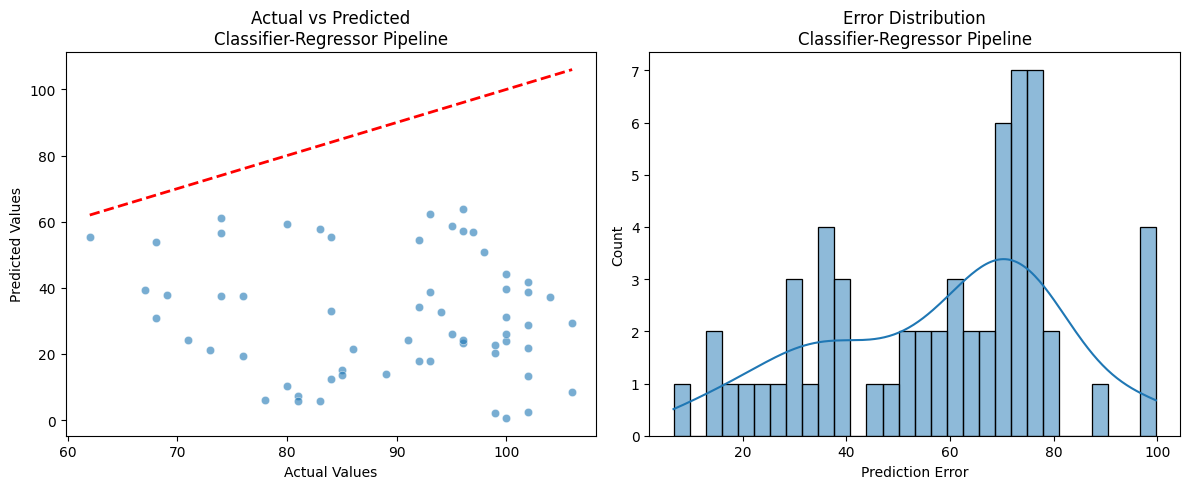

In [ ]:
#PCA
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.regularizers import l2

# Define RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Load data
train_df = pd.read_excel('/content/big_train_no_duples.xlsx')
X = train_df.drop(columns=['mass'])
y = train_df['mass']

# Define columns
numerical_cols = ['day', 'ph', '% second component']
categorical_cols = ['type of pha', 'environment', 'form', 'dimensionality', 'porosity',
                   'in vivo', 'enzymatic', 'environment_type', 'form_type']

# Function to compute and print PCA feature importance
def print_pca_feature_importance(preprocessor, numerical_cols, categorical_cols, model_name):
    col_transformer = preprocessor.named_steps['col_transformer']
    pca = preprocessor.named_steps['pca']

    # Get feature names after ColumnTransformer
    num_features = numerical_cols
    cat_transformer = col_transformer.named_transformers_['cat']
    onehot_encoder = cat_transformer.named_steps['onehot']
    cat_features = onehot_encoder.get_feature_names_out(categorical_cols)
    all_features = list(num_features) + list(cat_features)

    # Compute feature importance from PCA loadings
    loadings = pca.components_.T  # Shape: (n_features, n_components)
    explained_variance = pca.explained_variance_
    total_variance = np.sum(explained_variance)
    weights = explained_variance / total_variance
    feature_importance = np.sum((loadings ** 2) * weights, axis=1)

    # Aggregate importance for categorical features
    aggregated_importance = []
    for col in numerical_cols + categorical_cols:
        if col in numerical_cols:
            importance = feature_importance[all_features.index(col)]
            aggregated_importance.append((col, importance))
        else:
            related_features = [f for f in all_features if f.startswith(f"{col}_")]
            importance = sum(feature_importance[all_features.index(f)] for f in related_features)
            aggregated_importance.append((col, importance))

    # Create and print importance DataFrame
    importance_df = pd.DataFrame(aggregated_importance, columns=['Feature', 'Importance'])
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\nPCA Feature Importance for {model_name}:")
    print(f"{'Feature':<30}{'Importance':<15}")
    print("-" * 45)
    for _, row in importance_df.iterrows():
        print(f"{row['Feature']:<30}{row['Importance']:.6f}")

    return importance_df

# Define preprocessors with PCA
classifier_preprocessor = Pipeline(steps=[
    ('col_transformer', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols)
        ]
    )),
    ('pca', PCA(n_components=0.95))
])

cnn_preprocessor = Pipeline(steps=[
    ('col_transformer', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols)
        ]
    )),
    ('pca', PCA(n_components=0.95))
])

lr_preprocessor = Pipeline(steps=[
    ('col_transformer', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols)
        ]
    )),
    ('pca', PCA(n_components=0.95))
])

rf_preprocessor = Pipeline(steps=[
    ('col_transformer', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('robust', RobustScaler()),
                ('scaler', Normalizer())
            ]), numerical_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols)
        ]
    )),
    ('pca', PCA(n_components=0.95))
])

gb_preprocessor = Pipeline(steps=[
    ('col_transformer', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('robust', RobustScaler()),
                ('scaler', Normalizer())
            ]), numerical_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols)
        ]
    )),
    ('pca', PCA(n_components=0.95))
])

br_preprocessor = Pipeline(steps=[
    ('col_transformer', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols)
        ]
    )),
    ('pca', PCA(n_components=0.95))
])

# Apply preprocessing
X_classifier_preprocessed = classifier_preprocessor.fit_transform(X)
X_cnn_preprocessed = cnn_preprocessor.fit_transform(X)
X_lr_preprocessed = lr_preprocessor.fit_transform(X)
X_rf_preprocessed = rf_preprocessor.fit_transform(X)
X_gb_preprocessed = gb_preprocessor.fit_transform(X)
X_br_preprocessed = br_preprocessor.fit_transform(X)

# Print PCA feature importance for each model
print_pca_feature_importance(classifier_preprocessor, numerical_cols, categorical_cols, "Classifier")
print_pca_feature_importance(cnn_preprocessor, numerical_cols, categorical_cols, "CNN")
print_pca_feature_importance(lr_preprocessor, numerical_cols, categorical_cols, "Linear Regression")
print_pca_feature_importance(rf_preprocessor, numerical_cols, categorical_cols, "Random Forest")
print_pca_feature_importance(gb_preprocessor, numerical_cols, categorical_cols, "Gradient Boosting")
print_pca_feature_importance(br_preprocessor, numerical_cols, categorical_cols, "Bayesian Ridge")

# Define bins
bins_cnn = [-1] + [y.quantile(q) for q in [0, 0.25, 0.5, 0.75, 1]]
bins_lr = [-1] + [y.quantile(q) for q in [0, 0.25, 0.5, 0.75, 1]]
bins_rf = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 99, 110]
bins_gb = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 99, 110]
bins_br = [-1] + [y.quantile(q) for q in [0.15, 0.45, 0.75, 1]]
bins_clf = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 99, 110]

# Create binned labels
y_binned_cnn = pd.cut(y, bins=bins_cnn, labels=False, include_lowest=True)
y_binned_lr = pd.cut(y, bins=bins_lr, labels=False, include_lowest=True)
y_binned_rf = pd.cut(y, bins=bins_rf, labels=False, include_lowest=True)
y_binned_gb = pd.cut(y, bins=bins_gb, labels=False, include_lowest=True)
y_binned_br = pd.cut(y, bins=bins_br, labels=False, include_lowest=True)
y_binned_clf = pd.cut(y, bins=bins_clf, labels=False, include_lowest=True)

# Train-test split
X_train_clf, X_test_clf, X_train_cnn, X_test_cnn, X_train_lr, X_test_lr, X_train_rf, X_test_rf, X_train_gb, X_test_gb, X_train_br, X_test_br, y_train, y_test, y_train_binned_cnn, y_test_binned_cnn, y_train_binned_lr, y_test_binned_lr, y_train_binned_rf, y_test_binned_rf, y_train_binned_gb, y_test_binned_gb, y_train_binned_br, y_test_binned_br, y_train_binned_clf, y_test_binned_clf = train_test_split(
    X_classifier_preprocessed, X_cnn_preprocessed, X_lr_preprocessed, X_rf_preprocessed,
    X_gb_preprocessed, X_br_preprocessed, y,
    y_binned_cnn, y_binned_lr, y_binned_rf, y_binned_gb, y_binned_br, y_binned_clf,
    test_size= 0.2,
    random_state=42,
    stratify=y_binned_clf
)

# Apply separate ADASYN for each model
adasyn_cnn = ADASYN(sampling_strategy='minority', n_neighbors=3, random_state=42)
X_train_cnn_resampled, y_train_binned_cnn_resampled = adasyn_cnn.fit_resample(X_train_cnn, y_train_binned_cnn)

adasyn_lr = ADASYN(sampling_strategy='minority', n_neighbors=3, random_state=42)
X_train_lr_resampled, y_train_binned_lr_resampled = adasyn_lr.fit_resample(X_train_lr, y_train_binned_lr)

adasyn_rf = ADASYN(sampling_strategy='minority', n_neighbors=1, random_state=42)
X_train_rf_resampled, y_train_binned_rf_resampled = adasyn_rf.fit_resample(X_train_rf, y_train_binned_rf)

adasyn_gb = ADASYN(sampling_strategy='minority', n_neighbors=1, random_state=42)
X_train_gb_resampled, y_train_binned_gb_resampled = adasyn_gb.fit_resample(X_train_gb, y_train_binned_gb)

adasyn_br = ADASYN(sampling_strategy='minority', n_neighbors=3, random_state=42)
X_train_br_resampled, y_train_binned_br_resampled = adasyn_br.fit_resample(X_train_br, y_train_binned_br)

bin_centers_cnn = [(bins_cnn[i] + bins_cnn[i + 1]) / 2 for i in range(len(bins_cnn) - 1)]
bin_centers_lr = [(bins_lr[i] + bins_lr[i + 1]) / 2 for i in range(len(bins_lr) - 1)]
bin_centers_rf = [(bins_rf[i] + bins_rf[i + 1]) / 2 for i in range(len(bins_rf) - 1)]
bin_centers_gb = [(bins_gb[i] + bins_gb[i + 1]) / 2 for i in range(len(bins_gb) - 1)]
bin_centers_br = [(bins_br[i] + bins_br[i + 1]) / 2 for i in range(len(bins_br) - 1)]

y_train_cnn_resampled_cont = np.array([bin_centers_cnn[int(cls)] for cls in y_train_binned_cnn_resampled])
y_train_lr_resampled_cont = np.array([bin_centers_lr[int(cls)] for cls in y_train_binned_lr_resampled])
y_train_rf_resampled_cont = np.array([bin_centers_rf[int(cls)] for cls in y_train_binned_rf_resampled])
y_train_gb_resampled_cont = np.array([bin_centers_gb[int(cls)] for cls in y_train_binned_gb_resampled])
y_train_br_resampled_cont = np.array([bin_centers_br[int(cls)] for cls in y_train_binned_br_resampled])

# Compute sample weights
sample_weights_cnn = compute_sample_weight(class_weight='balanced', y=y_binned_cnn)
sample_weights_lr = compute_sample_weight(class_weight='balanced', y=y_binned_lr)
sample_weights_rf = compute_sample_weight(class_weight='balanced', y=y_binned_rf)
sample_weights_gb = compute_sample_weight(class_weight='balanced', y=y_binned_gb)
sample_weights_br = compute_sample_weight(class_weight='balanced', y=y_binned_br)
sample_weights_clf = compute_sample_weight(class_weight='balanced', y=y_binned_clf)

# Define CNN model with dynamic input shape
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, 1, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 1, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(BatchNormalization())
    model.add(Conv1D(256, 1, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-3)))
    model.add(Dense(1))
    optimizer = RMSprop(learning_rate=3e-4, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Learning rate schedule
def polynomial_decay_schedule(epoch, lr):
    power = 1.0
    max_epochs = 200
    return 3e-4 * (1 - epoch / max_epochs) ** power

callbacks = [LearningRateScheduler(polynomial_decay_schedule)]

# Parameter grids for GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.33]
}

param_grid_gb = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'subsample': [0.6, 0.8, 1.0]
}

param_grid_br = {
    'alpha_1': [1e-6, 1e-5, 1e-4],
    'alpha_2': [1e-6, 1e-5, 1e-4],
    'lambda_1': [1e-6, 1e-5, 1e-4],
    'lambda_2': [1e-6, 1e-5, 1e-4]
}

# Train models
models = {
    0: ('cnn', None),
    1: ('lr', LinearRegression()),
    2: ('rf', None),
    3: ('gb', None),
    4: ('br', None)
}

# Train CNN
X_train_cnn_3d = np.expand_dims(X_train_cnn_resampled, axis=1)
cnn_input_shape = (X_train_cnn_3d.shape[1], X_train_cnn_3d.shape[2])
cnn_model = create_cnn_model(cnn_input_shape)
cnn_model.fit(
    X_train_cnn_3d, y_train_cnn_resampled_cont,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    sample_weight=sample_weights_cnn,
    verbose=0
)
models[0] = ('cnn', cnn_model)

# Train Linear Regression
models[1][1].fit(X_train_lr_resampled, y_train_lr_resampled_cont, sample_weight=sample_weights_lr)

# GridSearchCV for RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train_rf_resampled, y_train_rf_resampled_cont, sample_weight=sample_weights_rf)
models[2] = ('rf', grid_search_rf.best_estimator_)
print("Best RandomForestRegressor parameters:", grid_search_rf.best_params_)

# GridSearchCV for GradientBoostingRegressor
gb = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_search_gb.fit(X_train_gb_resampled, y_train_gb_resampled_cont, sample_weight=sample_weights_gb)
models[3] = ('gb', grid_search_gb.best_estimator_)
print("Best GradientBoostingRegressor parameters:", grid_search_gb.best_params_)

# GridSearchCV for BayesianRidge
br = BayesianRidge()
grid_search_br = GridSearchCV(
    estimator=br,
    param_grid=param_grid_br,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_search_br.fit(X_train_br_resampled, y_train_br_resampled_cont, sample_weight=sample_weights_br)
models[4] = ('br', grid_search_br.best_estimator_)
print("Best BayesianRidge parameters:", grid_search_br.best_params_)

# Get predictions on test data
predictions = {}
X_test_cnn_3d = np.expand_dims(X_test_cnn, axis=1)
predictions[0] = cnn_model.predict(X_test_cnn_3d, verbose=0).flatten()
predictions[1] = models[1][1].predict(X_test_lr)
predictions[2] = models[2][1].predict(X_test_rf)
predictions[3] = models[3][1].predict(X_test_gb)
predictions[4] = models[4][1].predict(X_test_br)

# Apply calibration for RF and GB
rf_calibrator = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
rf_calibrator.fit(predictions[2].reshape(-1, 1), y_test)
predictions[2] = rf_calibrator.predict(predictions[2].reshape(-1, 1)).flatten()

gb_calibrator = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
gb_calibrator.fit(predictions[3].reshape(-1, 1), y_test)
predictions[3] = gb_calibrator.predict(predictions[3].reshape(-1, 1)).flatten()

# Determine best model for each test example
errors = np.abs(np.array([predictions[cls] - y_test for cls in range(5)]))
best_model_classes = np.argmin(errors, axis=0)

# Train classifier
classifier = RandomForestClassifier(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_features=0.33)
classifier.fit(X_test_clf, best_model_classes, sample_weight=sample_weights_clf)

# Prediction function
def predict_with_classifier(X_clf, X_cnn, X_lr, X_rf, X_gb, X_br, classifier, models, rf_calibrator, gb_calibrator):
    preds = []
    classes = classifier.predict(X_clf)
    X_cnn_3d = np.expand_dims(X_cnn, axis=1)
    for i, cls in enumerate(classes):
        model_name, model = models[cls]
        if model_name == 'cnn':
            pred = model.predict(X_cnn_3d[i:i+1], verbose=0).flatten()[0]
        elif model_name == 'lr':
            pred = model.predict(X_lr[i:i+1])[0]
        elif model_name == 'rf':
            pred = model.predict(X_rf[i:i+1])[0]
            pred = rf_calibrator.predict([[pred]])[0]
        elif model_name == 'gb':
            pred = model.predict(X_gb[i:i+1])[0]
            pred = gb_calibrator.predict([[pred]])[0]
        elif model_name == 'br':
            pred = model.predict(X_br[i:i+1])[0]
        preds.append(pred)
    return np.array(preds), classes

# Get predictions
y_pred_train, _ = predict_with_classifier(X_train_clf, X_train_cnn, X_train_lr, X_train_rf, X_train_gb, X_train_br, classifier, models, rf_calibrator, gb_calibrator)
y_pred_test, _ = predict_with_classifier(X_test_clf, X_test_cnn, X_test_lr, X_test_rf, X_test_gb, X_test_br, classifier, models, rf_calibrator, gb_calibrator)

# Load and preprocess validation data
val_df = pd.read_excel('/content/final_test.xlsx')
X_val = val_df.drop(columns=['mass'])
y_val = val_df['mass']
X_val_clf = classifier_preprocessor.transform(X_val)
X_val_cnn = cnn_preprocessor.transform(X_val)
X_val_lr = lr_preprocessor.transform(X_val)
X_val_rf = rf_preprocessor.transform(X_val)
X_val_gb = gb_preprocessor.transform(X_val)
X_val_br = br_preprocessor.transform(X_val)
y_pred_val, val_classes = predict_with_classifier(X_val_clf, X_val_cnn, X_val_lr, X_val_rf, X_val_gb, X_val_br, classifier, models, rf_calibrator, gb_calibrator)

# Compute metrics for base models
base_metrics = {}
model_names = {0: 'CNN', 1: 'Linear Regression', 2: 'Random Forest', 3: 'Gradient Boosting', 4: 'Bayesian Ridge'}

# CNN predictions
X_test_cnn_3d = np.expand_dims(X_test_cnn, axis=1)
X_val_cnn_3d = np.expand_dims(X_val_cnn, axis=1)
X_train_cnn_3d = np.expand_dims(X_train_cnn, axis=1)
cnn_train_pred = models[0][1].predict(X_train_cnn_3d, verbose=0).flatten()
cnn_test_pred = models[0][1].predict(X_test_cnn_3d, verbose=0).flatten()
cnn_val_pred = models[0][1].predict(X_val_cnn_3d, verbose=0).flatten()
base_metrics[0] = {
    'train_mae': mean_absolute_error(y_train, cnn_train_pred),
    'test_mae': mean_absolute_error(y_test, cnn_test_pred),
    'val_mae': mean_absolute_error(y_val, cnn_val_pred),
    'train_rmse': rmse(y_train, cnn_train_pred),
    'test_rmse': rmse(y_test, cnn_test_pred),
    'val_rmse': rmse(y_val, cnn_val_pred),
    'train_r2': r2_score(y_train, cnn_train_pred),
    'test_r2': r2_score(y_test, cnn_test_pred),
    'val_r2': r2_score(y_val, cnn_val_pred)
}

# Other models
for cls in [1, 2, 3, 4]:
    model_name, model = models[cls]
    train_pred = model.predict(eval(f'X_train_{model_name}'))
    test_pred = model.predict(eval(f'X_test_{model_name}'))
    val_pred = model.predict(eval(f'X_val_{model_name}'))

    # Apply calibration for RF and GB
    if model_name == 'rf':
        test_pred = rf_calibrator.predict(test_pred.reshape(-1, 1)).flatten()
        val_pred = rf_calibrator.predict(val_pred.reshape(-1, 1)).flatten()
    elif model_name == 'gb':
        test_pred = gb_calibrator.predict(test_pred.reshape(-1, 1)).flatten()
        val_pred = gb_calibrator.predict(val_pred.reshape(-1, 1)).flatten()

    base_metrics[cls] = {
        'train_mae': mean_absolute_error(y_train, train_pred),
        'test_mae': mean_absolute_error(y_test, test_pred),
        'val_mae': mean_absolute_error(y_val, val_pred),
        'train_rmse': rmse(y_train, train_pred),
        'test_rmse': rmse(y_test, test_pred),
        'val_rmse': rmse(y_val, val_pred),
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred),
        'val_r2': r2_score(y_val, val_pred)
    }

# Print base model metrics
print("\nBase Model Results (MAE, RMSE, R²):")
print(f"{'Model':<20}{'Metric':<12}{'Train':<12}{'Test':<12}{'Validation':<12}")
for cls in range(5):
    model_name = model_names[cls]
    metrics = base_metrics[cls]
    print(f"{model_name:<20}{'MAE':<12}{metrics['train_mae']:.4f}{'':<5}{metrics['test_mae']:.4f}{'':<5}{metrics['val_mae']:.4f}")
    print(f"{'':<20}{'RMSE':<12}{metrics['train_rmse']:.4f}{'':<5}{metrics['test_rmse']:.4f}{'':<5}{metrics['val_rmse']:.4f}")
    print(f"{'':<20}{'R²':<12}{metrics['train_r2']:.4f}{'':<5}{metrics['test_r2']:.4f}{'':<5}{metrics['val_r2']:.4f}")

# Choose best model on test set
test_maes = [base_metrics[cls]['test_mae'] for cls in range(5)]
best_model_idx = np.argmin(test_maes)
best_model_name = model_names[best_model_idx]
best_model_metrics = base_metrics[best_model_idx]

print("\nBest Model on Test Set:")
print(f"Model: {best_model_name}")
print(f"MAE: {best_model_metrics['test_mae']:.4f}")
print(f"RMSE: {best_model_metrics['test_rmse']:.4f}")
print(f"R²: {best_model_metrics['test_r2']:.4f}")

# Print validation class distribution
class_counts = Counter(val_classes)
total_samples = len(val_classes)
print("\nValidation Class Distribution (%):")
for cls in range(5):
    percentage = (class_counts.get(cls, 0) / total_samples * 100) if total_samples > 0 else 0
    print(f"{model_names[cls]} (Class {cls}): {percentage:.2f}%")

# Evaluate pipeline
results = {
    'train_mae': mean_absolute_error(y_train, y_pred_train),
    'test_mae': mean_absolute_error(y_test, y_pred_test),
    'val_mae': mean_absolute_error(y_val, y_pred_val),
    'train_rmse': rmse(y_train, y_pred_train),
    'test_rmse': rmse(y_test, y_pred_test),
    'val_rmse': rmse(y_val, y_pred_val),
    'train_r2': r2_score(y_train, y_pred_train),
    'test_r2': r2_score(y_test, y_pred_test),
    'val_r2': r2_score(y_val, y_pred_val)
}

# Print pipeline results
print("\nClassifier-Regressor Pipeline Results (MAE, RMSE, R²):")
print(f"{'Metric':<20}{'Train':<12}{'Test':<12}{'Validation':<12}")
print(f"{'MAE':<20}{results['train_mae']:.4f}{'':<5}{results['test_mae']:.4f}{'':<5}{results['val_mae']:.4f}")
print(f"{'RMSE':<20}{results['train_rmse']:.4f}{'':<5}{results['test_rmse']:.4f}{'':<5}{results['val_rmse']:.4f}")
print(f"{'R²':<20}{results['train_r2']:.4f}{'':<5}{results['test_r2']:.4f}{'':<5}{results['val_r2']:.4f}")

# Visualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_val, y=y_pred_val, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted\nClassifier-Regressor Pipeline')
plt.subplot(1, 2, 2)
errors = y_val - y_pred_val
sns.histplot(errors, kde=True, bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Error Distribution\nClassifier-Regressor Pipeline')
plt.tight_layout()
plt.savefig('classifier_regressor_results.png')